In [1]:
# dataset
from torchvision import datasets

from functools import partial
import numpy as np

# visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# preprocessing
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split

# model
import torch
from torch import nn
import torchvision.models as models
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

# hyperparameter tuning
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

# metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# 1. Load Data & Preprocessing

**Dataset**: <a href="https://www.cs.toronto.edu/~kriz/cifar.html" target="_blank">CIFAR-10</a>

**Classes**: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

The following transformations are tested:
* **resize**
* **center crop**
* **normalization**: from [0, 255] to [0, 1]
* **standardization**: by substracting the mean and dividing with std according to ImageNet

In [2]:
def load_data(data_dir):
    """ Create train and test pytorch dataset objects from CIFAR-10.
    
    The following tranformations are applied on CIFAR-10:
        * resize images,
        * center crop images,
        * normalization: from [0, 255] to [0, 1] by dividing with 255,
        * standardization: by substracting the mean and dividing with std according to ImageNet
    
    Args:
        data_dir:
            directory where data will be saved, as a string.
    
    Returns:
        train and test dataset, as pytorch dataset objects.
    """
    transform = transforms.Compose([
        transforms.Resize(224), 
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    trainset = datasets.CIFAR10(root=data_dir,
                                train=True, 
                                download=True, 
                                transform=transform)

    testset = datasets.CIFAR10(root=data_dir, 
                               train=False, 
                               download=True, 
                               transform=transform)

    return trainset, testset

In [3]:
trainset, testset = load_data(data_dir='cifar10-pytorch')

print(f'\nTraining data:\n--------------\n{trainset}')
print(f'Test data:\n--------------\n{testset}')

Files already downloaded and verified
Files already downloaded and verified

Training data:
--------------
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: cifar10-pytorch
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Test data:
--------------
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: cifar10-pytorch
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [4]:
batch_size = 64

train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# 2. VGG-16

We'll use the **pretrained version** of VGG-16. Since CIFAR-10 dataset has less classes than ImageNet, we'll keep all the layers **freezed**, except of the last one, which will be **unfreezed** and updated with the right number of classes and will be re-trained.

![VGG](images\vgg.png)

Regularization:
* Weight decay (L2 regularization)

Loss Function:
* Cross Entropy Loss

Optimizer and Scheduler:
* Adam optimizer
* ReduceLROnPlateau scheduler

In [5]:
def set_parameter_requires_grad(model, feature_extracting):
    """ This helper function sets the .requires_grad attribute of the parameters in the model 
    to False when we are feature extracting. 
    
    When we are feature extracting and only want to compute gradients for the newly initialized layer, 
    then we want all of the other parameters to not require gradients.
    
    Args:
        model: 
            deep learning model, as pytorch object.
        feature_extracting:
            whether or not we're feature extracting, as boolean.
    """
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [6]:
def initialize_model(num_labels, feature_extracting, pretrained=True):
    """ Initialize VGG-16 model and reshape the last layer with the correct number of classes.
    
    Since VGG-16 has been pretrained on Imagenet, it has output layers of size 1000, one node for each class. 
    We reshape the last layer to have the same number of inputs as before, and to have the same number of 
    outputs as the number of classes in our the dataset.
    
    Args:
        num_labels:
            number of labels in our dataset, as integer.
        feature_extracting:
          flag for feature extracting (when False, we finetune the whole model, 
          when True we only update the reshaped layer params), as boolean.
        pretrained:
            whether or not we want the pretrained version of AlexNet, as boolean.
    
    Returns:
        VGG-16 model, as pytorch object
    """
    model = models.vgg16(pretrained=pretrained)
    
    set_parameter_requires_grad(model, feature_extracting)
    
    last_layer_in_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(last_layer_in_ftrs, num_labels)
    
    return model

# 3. Hyperparameter Tuning

We'll use **early stopping** with **ASHAScheduler** to stop bad trials earlier.

|                               | Validation Loss | Validation Accuracy |
| :---------------------------: | :-------------: | :-----------------: |
| VGG-16                        | 0.40            | 86%                 |

Best trial **configuration** for VGG-16: lr: 0.001, l2: 0.001

In [7]:
def tune_helper(config, trainset, num_labels, batch_size, epochs):
    """ Fit deep learning model and test it on a hold-out validation set.
    
    The validation set is a 20% hold-out set of the training set. 
    The loss function used is Cross Entropy Loss.
    The optimer used is Adam and the scheduler that wraps the optimizer is ReduceLROnPlateau.
    The metric used is accuracy score.
    
    Args:
        config:
            hyperparameters of neural network, as a dictionary.
        trainset:
            training dataset, as a pytorch object.
        num_labels:
            number of labels, as an integer.
        batch_size:
            size of batches to be processed, as an integer.
        epochs:
            number of epochs (times the neural network will see the data), as an integer.
    """
    feature_extracting = True
    pretrained = True
    model = initialize_model(num_labels=num_labels, 
                             feature_extracting=feature_extracting, 
                             pretrained=pretrained)
    
    # support data parallel training on multiple GPUs
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)
    
    # create an optimizer that only updates the desired parameters
    params_to_update = model.parameters()
    print("Parameters to learn:")
    if feature_extracting:
        params_to_update = []
        for name, param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t", name)
    else:
        for name, param in model.named_parameters():
            if param.requires_grad == True:
                print("\t", name)
    
    # optimizer
    optimizer = AdamW(params_to_update, lr=config['lr'], weight_decay=config['l2'])
    
    #scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min')
    
    
    # loss function
    loss_fn = nn.CrossEntropyLoss()
    
    # split data: training (80%) - validation (20%)
    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(trainset, [test_abs, len(trainset) - test_abs])

    train_dataloader = DataLoader(train_subset,
                                  batch_size=batch_size,
                                  shuffle=True, 
                                  num_workers=2)
    
    val_dataloader = DataLoader(val_subset,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=2)
    
    for epoch in range(epochs):
        # fit neural network on training data
        model.train()  # put on train mode
        for batch, (X, Y) in enumerate(train_dataloader, 0):
            # send the data to the GPU memory explicitly
            X, Y = X.to(device), Y.to(device)

            # reset the gradients
            optimizer.zero_grad()
            
            # compute prediction
            pred = model(X)

            # compute loss
            loss = loss_fn(pred, Y)

            # backpropagate
            loss.backward()

            # update parameters
            optimizer.step()
        
        # test on validation data
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        model.eval()  # put on evaluation mode
        for batch, (X, Y) in enumerate(val_dataloader, 0):
            with torch.no_grad():
                X, Y = X.to(device), Y.to(device)

                pred = model(X)
                
                _, predicted = torch.max(pred.data, 1)
                total += Y.size(0)
                correct += (predicted == Y).sum().item()

                loss = loss_fn(pred, Y)
                val_loss += loss.cpu().numpy()
                val_steps += 1
        
        # update scheduler
        scheduler.step(val_loss)
        
        # report metrics
        tune.report(loss=(val_loss / val_steps), accuracy=(correct / total))

In [8]:
def hyperparameter_tune(data_dir,
                        batch_size,
                        epochs,
                        config,
                        grace_period,
                        num_samples, 
                        cpus_per_trial,
                        gpus_per_trial):
    """ Run hyperparameter tuning and report best hyperparameters.
    
    Args:
        data_dir:
            directory where CIFAR-10 data will be saved/loaded, as a string.
        batch_size:
            size of batches to be processed, as an integer.
        epochs:
            number of epochs (times the neural network will see the data), as an integer.
        config:
            hyperparametes, as a dictionary.
        grace_period:
            stop trials at least this old in time, as an integer.
        num_samples:
            number of times to sample from the hyperparameter space (if grid_search is provided as an argument,
            the grid will be repeated num_samples of times), as an integer.
        cpus_per_trial:
            CPUs to allocate per trial, as integer.
        gpus_per_trial:
            GPUs to allocate per trial, as integer.
    """
    trainset, testset = load_data(data_dir=data_dir)
    
    num_labels = 10
    
    # hyperparameter search space
    cofig = config
    
    # used for early stopping
    scheduler = ASHAScheduler(metric="loss", 
                              mode="min",
                              max_t=epochs,
                              grace_period=grace_period,
                              reduction_factor=2)
    
    reporter = CLIReporter(metric_columns=["loss", "accuracy", "training_iteration"])
    
    # hyperparamet tuning
    result = tune.run(tune.with_parameters(tune_helper,
                                           trainset=trainset,
                                           num_labels=num_labels,
                                           batch_size=batch_size,
                                           epochs=epochs),
                      resources_per_trial={"cpu": cpus_per_trial, "gpu": gpus_per_trial},
                      config=config,
                      num_samples=num_samples,
                      scheduler=scheduler,
                      progress_reporter=reporter)
    
    # report best results
    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(best_trial.last_result["loss"]))
    print("Best trial final validation acurracy: {}".format(best_trial.last_result["accuracy"]))

In [9]:
# hyperparameter search space
config = {
    "lr": tune.grid_search([1e-3, 1e-4]),
    "l2": tune.grid_search([1e-3, 1e-4])
    }

In [10]:
hyperparameter_tune(data_dir='cifar10-pytorch',
                    batch_size=64,
                    epochs=100,
                    config=config,
                    grace_period=10,
                    num_samples=1, 
                    cpus_per_trial=0,
                    gpus_per_trial=1)

Files already downloaded and verified
Files already downloaded and verified


2021-08-29 18:55:27,036	INFO services.py:1247 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-29 18:55:41,400	WARNING function_runner.py:545 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
2021-08-29 18:55:42,634	ERROR syncer.py:72 -- Log sync requires rsync to be installed.


== Status ==
Memory usage on this node: 6.7/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 0/8 CPUs, 0/1 GPUs, 0.0/0.92 GiB heap, 0.0/0.46 GiB objects
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_18-55-41
Number of trials: 4/4 (4 PENDING)
+-------------------------+----------+-------+--------+--------+
| Trial name              | status   | loc   |     l2 |     lr |
|-------------------------+----------+-------+--------+--------|
| tune_helper_8fdc1_00000 | PENDING  |       | 0.001  | 0.001  |
| tune_helper_8fdc1_00001 | PENDING  |       | 0.0001 | 0.001  |
| tune_helper_8fdc1_00002 | PENDING  |       | 0.001  | 0.0001 |
| tune_helper_8fdc1_00003 | PENDING  |       | 0.0001 | 0.0001 |
+-------------------------+----------+-------+--------+--------+


== Status ==
Memory usage on this node: 6.8/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None

(pid=15212) C:\Users\lampr\anaconda3\envs\cbir-dl\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
(pid=15212)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for tune_helper_8fdc1_00000:
  accuracy: 0.8336
  date: 2021-08-29_19-09-12
  done: false
  experiment_id: 7b1ba9ac6c0144a4bc2d1e33bee85f3e
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 1
  loss: 0.4804305475988206
  node_ip: 192.168.1.18
  pid: 15212
  time_since_restore: 796.0450284481049
  time_this_iter_s: 796.0450284481049
  time_total_s: 796.0450284481049
  timestamp: 1630253352
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 8fdc1_00000
  
== Status ==
Memory usage on this node: 5.8/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/0.92 GiB heap, 0.0/0.46 GiB objects (0.0/1.0 GPU_group_0_bd4642f576e1f5e55705753b11f52f8e, 0.0/1.0 GPU_group_bd4642f576e1f5e55705753b11f52f8e)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_18-55-41
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----

Result for tune_helper_8fdc1_00000:
  accuracy: 0.8403
  date: 2021-08-29_20-04-43
  done: false
  experiment_id: 7b1ba9ac6c0144a4bc2d1e33bee85f3e
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 6
  loss: 0.46187620481867697
  node_ip: 192.168.1.18
  pid: 15212
  time_since_restore: 4127.294302940369
  time_this_iter_s: 670.4401874542236
  time_total_s: 4127.294302940369
  timestamp: 1630256683
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 8fdc1_00000
  
== Status ==
Memory usage on this node: 5.8/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/0.92 GiB heap, 0.0/0.46 GiB objects (0.0/1.0 GPU_group_0_bd4642f576e1f5e55705753b11f52f8e, 0.0/1.0 GPU_group_bd4642f576e1f5e55705753b11f52f8e)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_18-55-41
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+---

Result for tune_helper_8fdc1_00000:
  accuracy: 0.8475
  date: 2021-08-29_21-00-00
  done: false
  experiment_id: 7b1ba9ac6c0144a4bc2d1e33bee85f3e
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 11
  loss: 0.43867540796091603
  node_ip: 192.168.1.18
  pid: 15212
  time_since_restore: 7443.7054579257965
  time_this_iter_s: 661.9251222610474
  time_total_s: 7443.7054579257965
  timestamp: 1630260000
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 8fdc1_00000
  
== Status ==
Memory usage on this node: 5.7/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -0.43670924188225135
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/0.92 GiB heap, 0.0/0.46 GiB objects (0.0/1.0 GPU_group_0_bd4642f576e1f5e55705753b11f52f8e, 0.0/1.0 GPU_group_bd4642f576e1f5e55705753b11f52f8e)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_18-55-41
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+---------

Result for tune_helper_8fdc1_00000:
  accuracy: 0.8471
  date: 2021-08-29_21-55-19
  done: false
  experiment_id: 7b1ba9ac6c0144a4bc2d1e33bee85f3e
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 16
  loss: 0.4566468738826217
  node_ip: 192.168.1.18
  pid: 15212
  time_since_restore: 10763.4414665699
  time_this_iter_s: 661.3524398803711
  time_total_s: 10763.4414665699
  timestamp: 1630263319
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 8fdc1_00000
  
== Status ==
Memory usage on this node: 5.2/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -0.43670924188225135
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/0.92 GiB heap, 0.0/0.46 GiB objects (0.0/1.0 GPU_group_0_bd4642f576e1f5e55705753b11f52f8e, 0.0/1.0 GPU_group_bd4642f576e1f5e55705753b11f52f8e)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_18-55-41
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+--------------

Result for tune_helper_8fdc1_00000:
  accuracy: 0.8481
  date: 2021-08-29_22-50-40
  done: false
  experiment_id: 7b1ba9ac6c0144a4bc2d1e33bee85f3e
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 21
  loss: 0.44821126891928875
  node_ip: 192.168.1.18
  pid: 15212
  time_since_restore: 14084.630011558533
  time_this_iter_s: 663.5349750518799
  time_total_s: 14084.630011558533
  timestamp: 1630266640
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: 8fdc1_00000
  
== Status ==
Memory usage on this node: 5.1/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -0.4555565627517214 | Iter 10.000: -0.43670924188225135
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/0.92 GiB heap, 0.0/0.46 GiB objects (0.0/1.0 GPU_group_0_bd4642f576e1f5e55705753b11f52f8e, 0.0/1.0 GPU_group_bd4642f576e1f5e55705753b11f52f8e)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_18-55-41
Number of trials: 4/4 (3 PENDING, 1 RUNN

Result for tune_helper_8fdc1_00000:
  accuracy: 0.8569
  date: 2021-08-29_23-46-25
  done: false
  experiment_id: 7b1ba9ac6c0144a4bc2d1e33bee85f3e
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 26
  loss: 0.41523843785380105
  node_ip: 192.168.1.18
  pid: 15212
  time_since_restore: 17429.186593532562
  time_this_iter_s: 671.6890299320221
  time_total_s: 17429.186593532562
  timestamp: 1630269985
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: 8fdc1_00000
  
== Status ==
Memory usage on this node: 5.2/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -0.4555565627517214 | Iter 10.000: -0.43670924188225135
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/0.92 GiB heap, 0.0/0.46 GiB objects (0.0/1.0 GPU_group_0_bd4642f576e1f5e55705753b11f52f8e, 0.0/1.0 GPU_group_bd4642f576e1f5e55705753b11f52f8e)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_18-55-41
Number of trials: 4/4 (3 PENDING, 1 RUNN

Result for tune_helper_8fdc1_00000:
  accuracy: 0.8586
  date: 2021-08-30_00-42-31
  done: false
  experiment_id: 7b1ba9ac6c0144a4bc2d1e33bee85f3e
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 31
  loss: 0.4103551857220899
  node_ip: 192.168.1.18
  pid: 15212
  time_since_restore: 20795.34463763237
  time_this_iter_s: 671.4015874862671
  time_total_s: 20795.34463763237
  timestamp: 1630273351
  timesteps_since_restore: 0
  training_iteration: 31
  trial_id: 8fdc1_00000
  
== Status ==
Memory usage on this node: 4.9/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -0.4555565627517214 | Iter 10.000: -0.43670924188225135
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/0.92 GiB heap, 0.0/0.46 GiB objects (0.0/1.0 GPU_group_bd4642f576e1f5e55705753b11f52f8e, 0.0/1.0 GPU_group_0_bd4642f576e1f5e55705753b11f52f8e)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_18-55-41
Number of trials: 4/4 (3 PENDING, 1 RUNNING

Result for tune_helper_8fdc1_00000:
  accuracy: 0.8603
  date: 2021-08-30_01-38-47
  done: false
  experiment_id: 7b1ba9ac6c0144a4bc2d1e33bee85f3e
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 36
  loss: 0.40936171334640237
  node_ip: 192.168.1.18
  pid: 15212
  time_since_restore: 24171.297172307968
  time_this_iter_s: 670.7186527252197
  time_total_s: 24171.297172307968
  timestamp: 1630276727
  timesteps_since_restore: 0
  training_iteration: 36
  trial_id: 8fdc1_00000
  
== Status ==
Memory usage on this node: 5.0/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -0.4555565627517214 | Iter 10.000: -0.43670924188225135
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/0.92 GiB heap, 0.0/0.46 GiB objects (0.0/1.0 GPU_group_bd4642f576e1f5e55705753b11f52f8e, 0.0/1.0 GPU_group_0_bd4642f576e1f5e55705753b11f52f8e)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_18-55-41
Number of trials: 4/4 (3 PENDING, 1 RUNN

Result for tune_helper_8fdc1_00000:
  accuracy: 0.8608
  date: 2021-08-30_02-34-48
  done: false
  experiment_id: 7b1ba9ac6c0144a4bc2d1e33bee85f3e
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 41
  loss: 0.40783311958145946
  node_ip: 192.168.1.18
  pid: 15212
  time_since_restore: 27532.6038043499
  time_this_iter_s: 669.7361915111542
  time_total_s: 27532.6038043499
  timestamp: 1630280088
  timesteps_since_restore: 0
  training_iteration: 41
  trial_id: 8fdc1_00000
  
== Status ==
Memory usage on this node: 5.1/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -0.4127934423221904 | Iter 20.000: -0.4555565627517214 | Iter 10.000: -0.43670924188225135
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/0.92 GiB heap, 0.0/0.46 GiB objects (0.0/1.0 GPU_group_bd4642f576e1f5e55705753b11f52f8e, 0.0/1.0 GPU_group_0_bd4642f576e1f5e55705753b11f52f8e)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_18-55-41
Number of trials: 4/4 (3 PEND

Result for tune_helper_8fdc1_00000:
  accuracy: 0.8592
  date: 2021-08-30_03-30-56
  done: false
  experiment_id: 7b1ba9ac6c0144a4bc2d1e33bee85f3e
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 46
  loss: 0.41207591297140544
  node_ip: 192.168.1.18
  pid: 15212
  time_since_restore: 30900.26754808426
  time_this_iter_s: 675.5736198425293
  time_total_s: 30900.26754808426
  timestamp: 1630283456
  timesteps_since_restore: 0
  training_iteration: 46
  trial_id: 8fdc1_00000
  
== Status ==
Memory usage on this node: 5.3/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -0.4127934423221904 | Iter 20.000: -0.4555565627517214 | Iter 10.000: -0.43670924188225135
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/0.92 GiB heap, 0.0/0.46 GiB objects (0.0/1.0 GPU_group_0_bd4642f576e1f5e55705753b11f52f8e, 0.0/1.0 GPU_group_bd4642f576e1f5e55705753b11f52f8e)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_18-55-41
Number of trials: 4/4 (3 PE

Result for tune_helper_8fdc1_00000:
  accuracy: 0.8577
  date: 2021-08-30_04-26-53
  done: false
  experiment_id: 7b1ba9ac6c0144a4bc2d1e33bee85f3e
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 51
  loss: 0.4094058762120593
  node_ip: 192.168.1.18
  pid: 15212
  time_since_restore: 34257.08680438995
  time_this_iter_s: 669.2001731395721
  time_total_s: 34257.08680438995
  timestamp: 1630286813
  timesteps_since_restore: 0
  training_iteration: 51
  trial_id: 8fdc1_00000
  
== Status ==
Memory usage on this node: 5.3/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -0.4127934423221904 | Iter 20.000: -0.4555565627517214 | Iter 10.000: -0.43670924188225135
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/0.92 GiB heap, 0.0/0.46 GiB objects (0.0/1.0 GPU_group_0_bd4642f576e1f5e55705753b11f52f8e, 0.0/1.0 GPU_group_bd4642f576e1f5e55705753b11f52f8e)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_18-55-41
Number of trials: 4/4 (3 PEN

Result for tune_helper_8fdc1_00000:
  accuracy: 0.863
  date: 2021-08-30_05-22-59
  done: false
  experiment_id: 7b1ba9ac6c0144a4bc2d1e33bee85f3e
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 56
  loss: 0.4079122414254838
  node_ip: 192.168.1.18
  pid: 15212
  time_since_restore: 37623.39644598961
  time_this_iter_s: 667.4299986362457
  time_total_s: 37623.39644598961
  timestamp: 1630290179
  timesteps_since_restore: 0
  training_iteration: 56
  trial_id: 8fdc1_00000
  
== Status ==
Memory usage on this node: 5.3/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -0.4127934423221904 | Iter 20.000: -0.4555565627517214 | Iter 10.000: -0.43670924188225135
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/0.92 GiB heap, 0.0/0.46 GiB objects (0.0/1.0 GPU_group_0_bd4642f576e1f5e55705753b11f52f8e, 0.0/1.0 GPU_group_bd4642f576e1f5e55705753b11f52f8e)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_18-55-41
Number of trials: 4/4 (3 PEND

Result for tune_helper_8fdc1_00000:
  accuracy: 0.8618
  date: 2021-08-30_06-18-44
  done: false
  experiment_id: 7b1ba9ac6c0144a4bc2d1e33bee85f3e
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 61
  loss: 0.4066490684724917
  node_ip: 192.168.1.18
  pid: 15212
  time_since_restore: 40968.59190130234
  time_this_iter_s: 669.2099969387054
  time_total_s: 40968.59190130234
  timestamp: 1630293524
  timesteps_since_restore: 0
  training_iteration: 61
  trial_id: 8fdc1_00000
  
== Status ==
Memory usage on this node: 5.2/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -0.4127934423221904 | Iter 20.000: -0.4555565627517214 | Iter 10.000: -0.43670924188225135
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/0.92 GiB heap, 0.0/0.46 GiB objects (0.0/1.0 GPU_group_0_bd4642f576e1f5e55705753b11f52f8e, 0.0/1.0 GPU_group_bd4642f576e1f5e55705753b11f52f8e)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_18-55-41
Number of trials: 4/4 (3 PEN

Result for tune_helper_8fdc1_00000:
  accuracy: 0.8627
  date: 2021-08-30_07-14-31
  done: false
  experiment_id: 7b1ba9ac6c0144a4bc2d1e33bee85f3e
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 66
  loss: 0.40806604485223247
  node_ip: 192.168.1.18
  pid: 15212
  time_since_restore: 44314.79771113396
  time_this_iter_s: 668.1791326999664
  time_total_s: 44314.79771113396
  timestamp: 1630296871
  timesteps_since_restore: 0
  training_iteration: 66
  trial_id: 8fdc1_00000
  
== Status ==
Memory usage on this node: 5.3/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -0.4127934423221904 | Iter 20.000: -0.4555565627517214 | Iter 10.000: -0.43670924188225135
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/0.92 GiB heap, 0.0/0.46 GiB objects (0.0/1.0 GPU_group_0_bd4642f576e1f5e55705753b11f52f8e, 0.0/1.0 GPU_group_bd4642f576e1f5e55705753b11f52f8e)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_18-55-41
Number of trials: 4/4 (3 PE

Result for tune_helper_8fdc1_00000:
  accuracy: 0.8622
  date: 2021-08-30_08-10-25
  done: false
  experiment_id: 7b1ba9ac6c0144a4bc2d1e33bee85f3e
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 71
  loss: 0.4066327310102001
  node_ip: 192.168.1.18
  pid: 15212
  time_since_restore: 47668.65982031822
  time_this_iter_s: 670.1343338489532
  time_total_s: 47668.65982031822
  timestamp: 1630300225
  timesteps_since_restore: 0
  training_iteration: 71
  trial_id: 8fdc1_00000
  
== Status ==
Memory usage on this node: 5.2/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -0.4127934423221904 | Iter 20.000: -0.4555565627517214 | Iter 10.000: -0.43670924188225135
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/0.92 GiB heap, 0.0/0.46 GiB objects (0.0/1.0 GPU_group_bd4642f576e1f5e55705753b11f52f8e, 0.0/1.0 GPU_group_0_bd4642f576e1f5e55705753b11f52f8e)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_18-55-41
Number of trials: 4/4 (3 PEN

Result for tune_helper_8fdc1_00000:
  accuracy: 0.8619
  date: 2021-08-30_09-06-25
  done: false
  experiment_id: 7b1ba9ac6c0144a4bc2d1e33bee85f3e
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 76
  loss: 0.40730894200361456
  node_ip: 192.168.1.18
  pid: 15212
  time_since_restore: 51029.335121393204
  time_this_iter_s: 671.3758111000061
  time_total_s: 51029.335121393204
  timestamp: 1630303585
  timesteps_since_restore: 0
  training_iteration: 76
  trial_id: 8fdc1_00000
  
== Status ==
Memory usage on this node: 5.1/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: -0.4127934423221904 | Iter 20.000: -0.4555565627517214 | Iter 10.000: -0.43670924188225135
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/0.92 GiB heap, 0.0/0.46 GiB objects (0.0/1.0 GPU_group_0_bd4642f576e1f5e55705753b11f52f8e, 0.0/1.0 GPU_group_bd4642f576e1f5e55705753b11f52f8e)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_18-55-41
Number of trials: 4/4 (3 

Result for tune_helper_8fdc1_00000:
  accuracy: 0.8621
  date: 2021-08-30_10-01-46
  done: false
  experiment_id: 7b1ba9ac6c0144a4bc2d1e33bee85f3e
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 81
  loss: 0.40633966750020434
  node_ip: 192.168.1.18
  pid: 15212
  time_since_restore: 54350.34031867981
  time_this_iter_s: 660.7179696559906
  time_total_s: 54350.34031867981
  timestamp: 1630306906
  timesteps_since_restore: 0
  training_iteration: 81
  trial_id: 8fdc1_00000
  
== Status ==
Memory usage on this node: 4.9/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: -0.40738995686458174 | Iter 40.000: -0.4127934423221904 | Iter 20.000: -0.4555565627517214 | Iter 10.000: -0.43670924188225135
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/0.92 GiB heap, 0.0/0.46 GiB objects (0.0/1.0 GPU_group_0_bd4642f576e1f5e55705753b11f52f8e, 0.0/1.0 GPU_group_bd4642f576e1f5e55705753b11f52f8e)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_18-55-41
Number of t

Result for tune_helper_8fdc1_00000:
  accuracy: 0.862
  date: 2021-08-30_10-57-02
  done: false
  experiment_id: 7b1ba9ac6c0144a4bc2d1e33bee85f3e
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 86
  loss: 0.40791011350170064
  node_ip: 192.168.1.18
  pid: 15212
  time_since_restore: 57666.1784453392
  time_this_iter_s: 667.4373033046722
  time_total_s: 57666.1784453392
  timestamp: 1630310222
  timesteps_since_restore: 0
  training_iteration: 86
  trial_id: 8fdc1_00000
  
== Status ==
Memory usage on this node: 5.3/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: -0.40738995686458174 | Iter 40.000: -0.4127934423221904 | Iter 20.000: -0.4555565627517214 | Iter 10.000: -0.43670924188225135
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/0.92 GiB heap, 0.0/0.46 GiB objects (0.0/1.0 GPU_group_0_bd4642f576e1f5e55705753b11f52f8e, 0.0/1.0 GPU_group_bd4642f576e1f5e55705753b11f52f8e)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_18-55-41
Number of tria

Result for tune_helper_8fdc1_00000:
  accuracy: 0.8623
  date: 2021-08-30_11-52-34
  done: false
  experiment_id: 7b1ba9ac6c0144a4bc2d1e33bee85f3e
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 91
  loss: 0.4093622141962598
  node_ip: 192.168.1.18
  pid: 15212
  time_since_restore: 60997.83089661598
  time_this_iter_s: 671.0447719097137
  time_total_s: 60997.83089661598
  timestamp: 1630313554
  timesteps_since_restore: 0
  training_iteration: 91
  trial_id: 8fdc1_00000
  
== Status ==
Memory usage on this node: 5.1/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: -0.40738995686458174 | Iter 40.000: -0.4127934423221904 | Iter 20.000: -0.4555565627517214 | Iter 10.000: -0.43670924188225135
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/0.92 GiB heap, 0.0/0.46 GiB objects (0.0/1.0 GPU_group_bd4642f576e1f5e55705753b11f52f8e, 0.0/1.0 GPU_group_0_bd4642f576e1f5e55705753b11f52f8e)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_18-55-41
Number of tr

Result for tune_helper_8fdc1_00000:
  accuracy: 0.8629
  date: 2021-08-30_12-47-39
  done: false
  experiment_id: 7b1ba9ac6c0144a4bc2d1e33bee85f3e
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 96
  loss: 0.4071857914992958
  node_ip: 192.168.1.18
  pid: 15212
  time_since_restore: 64302.691885471344
  time_this_iter_s: 661.0621693134308
  time_total_s: 64302.691885471344
  timestamp: 1630316859
  timesteps_since_restore: 0
  training_iteration: 96
  trial_id: 8fdc1_00000
  
== Status ==
Memory usage on this node: 5.0/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: -0.40738995686458174 | Iter 40.000: -0.4127934423221904 | Iter 20.000: -0.4555565627517214 | Iter 10.000: -0.43670924188225135
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/0.92 GiB heap, 0.0/0.46 GiB objects (0.0/1.0 GPU_group_0_bd4642f576e1f5e55705753b11f52f8e, 0.0/1.0 GPU_group_bd4642f576e1f5e55705753b11f52f8e)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_18-55-41
Number of 

2021-08-30 13:31:59,814	WARNING util.py:164 -- The `process_trial_result` operation took 0.505 s, which may be a performance bottleneck.
2021-08-30 13:31:59,854	WARNING util.py:164 -- Processing trial results took 0.545 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2021-08-30 13:31:59,869	WARNING util.py:164 -- The `process_trial` operation took 0.560 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.2/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: -0.40738995686458174 | Iter 40.000: -0.4127934423221904 | Iter 20.000: -0.4555565627517214 | Iter 10.000: -0.43670924188225135
Resources requested: 0/8 CPUs, 0/1 GPUs, 0.0/0.92 GiB heap, 0.0/0.46 GiB objects (0.0/1.0 GPU_group_0_bd4642f576e1f5e55705753b11f52f8e, 0.0/1.0 GPU_group_bd4642f576e1f5e55705753b11f52f8e)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_18-55-41
Number of trials: 4/4 (3 PENDING, 1 TERMINATED)
+-------------------------+------------+-------+--------+--------+----------+------------+----------------------+
| Trial name              | status     | loc   |     l2 |     lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+-------+--------+--------+----------+------------+----------------------|
| tune_helper_8fdc1_00001 | PENDING    |       | 0.0001 | 0.001  |          |            |                     

2021-08-30 13:32:00,803	WARNING util.py:164 -- The `start_trial` operation took 0.831 s, which may be a performance bottleneck.
(pid=15212) Windows fatal exception: access violation
(pid=15212) 


(pid=5048) Parameters to learn:
(pid=5048) 	 classifier.6.weight
(pid=5048) 	 classifier.6.bias


(pid=5048) C:\Users\lampr\anaconda3\envs\cbir-dl\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
(pid=5048)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for tune_helper_8fdc1_00001:
  accuracy: 0.8276
  date: 2021-08-30_13-44-30
  done: false
  experiment_id: 4b28c619adbf4079813bebbedb8a592f
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 1
  loss: 0.48914511852962955
  node_ip: 192.168.1.18
  pid: 5048
  time_since_restore: 729.2347340583801
  time_this_iter_s: 729.2347340583801
  time_total_s: 729.2347340583801
  timestamp: 1630320270
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 8fdc1_00001
  
== Status ==
Memory usage on this node: 6.7/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: -0.40738995686458174 | Iter 40.000: -0.4127934423221904 | Iter 20.000: -0.4555565627517214 | Iter 10.000: -0.43670924188225135
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/0.92 GiB heap, 0.0/0.46 GiB objects (0.0/1.0 GPU_group_bd4642f576e1f5e55705753b11f52f8e, 0.0/1.0 GPU_group_0_bd4642f576e1f5e55705753b11f52f8e)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_18-55-41
Number of tria

Result for tune_helper_8fdc1_00001:
  accuracy: 0.8423
  date: 2021-08-30_14-29-03
  done: false
  experiment_id: 4b28c619adbf4079813bebbedb8a592f
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 5
  loss: 0.45480369980547836
  node_ip: 192.168.1.18
  pid: 5048
  time_since_restore: 3402.4653623104095
  time_this_iter_s: 679.5878331661224
  time_total_s: 3402.4653623104095
  timestamp: 1630322943
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 8fdc1_00001
  
== Status ==
Memory usage on this node: 6.4/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: -0.40738995686458174 | Iter 40.000: -0.4127934423221904 | Iter 20.000: -0.4555565627517214 | Iter 10.000: -0.43670924188225135
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/0.92 GiB heap, 0.0/0.46 GiB objects (0.0/1.0 GPU_group_bd4642f576e1f5e55705753b11f52f8e, 0.0/1.0 GPU_group_0_bd4642f576e1f5e55705753b11f52f8e)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_18-55-41
Number of tr

Result for tune_helper_8fdc1_00001:
  accuracy: 0.8446
  date: 2021-08-30_15-13-06
  done: false
  experiment_id: 4b28c619adbf4079813bebbedb8a592f
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 9
  loss: 0.4551058959239607
  node_ip: 192.168.1.18
  pid: 5048
  time_since_restore: 6045.672644853592
  time_this_iter_s: 660.3024294376373
  time_total_s: 6045.672644853592
  timestamp: 1630325586
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 8fdc1_00001
  
== Status ==
Memory usage on this node: 6.3/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: -0.40738995686458174 | Iter 40.000: -0.4127934423221904 | Iter 20.000: -0.4555565627517214 | Iter 10.000: -0.43670924188225135
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/0.92 GiB heap, 0.0/0.46 GiB objects (0.0/1.0 GPU_group_0_bd4642f576e1f5e55705753b11f52f8e, 0.0/1.0 GPU_group_bd4642f576e1f5e55705753b11f52f8e)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_18-55-41
Number of trial

2021-08-30 15:24:07,063	WARNING util.py:164 -- The `start_trial` operation took 0.811 s, which may be a performance bottleneck.
(pid=5048) Windows fatal exception: access violation
(pid=5048) 


(pid=6700) Parameters to learn:
(pid=6700) 	 classifier.6.weight
(pid=6700) 	 classifier.6.bias


(pid=6700) C:\Users\lampr\anaconda3\envs\cbir-dl\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
(pid=6700)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for tune_helper_8fdc1_00002:
  accuracy: 0.7943
  date: 2021-08-30_15-36-08
  done: false
  experiment_id: 451b136fab994a52a95dbc9c73975495
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 1
  loss: 0.6490887642666033
  node_ip: 192.168.1.18
  pid: 6700
  time_since_restore: 703.1334044933319
  time_this_iter_s: 703.1334044933319
  time_total_s: 703.1334044933319
  timestamp: 1630326968
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 8fdc1_00002
  
== Status ==
Memory usage on this node: 6.5/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: -0.40738995686458174 | Iter 40.000: -0.4127934423221904 | Iter 20.000: -0.4555565627517214 | Iter 10.000: -0.44640106914244637
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/0.92 GiB heap, 0.0/0.46 GiB objects (0.0/1.0 GPU_group_0_bd4642f576e1f5e55705753b11f52f8e, 0.0/1.0 GPU_group_bd4642f576e1f5e55705753b11f52f8e)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_18-55-41
Number of trial

Result for tune_helper_8fdc1_00002:
  accuracy: 0.8259
  date: 2021-08-30_16-20-30
  done: false
  experiment_id: 451b136fab994a52a95dbc9c73975495
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 5
  loss: 0.5037329090628654
  node_ip: 192.168.1.18
  pid: 6700
  time_since_restore: 3365.1680080890656
  time_this_iter_s: 659.9274296760559
  time_total_s: 3365.1680080890656
  timestamp: 1630329630
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 8fdc1_00002
  
== Status ==
Memory usage on this node: 5.7/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: -0.40738995686458174 | Iter 40.000: -0.4127934423221904 | Iter 20.000: -0.4555565627517214 | Iter 10.000: -0.44640106914244637
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/0.92 GiB heap, 0.0/0.46 GiB objects (0.0/1.0 GPU_group_0_bd4642f576e1f5e55705753b11f52f8e, 0.0/1.0 GPU_group_bd4642f576e1f5e55705753b11f52f8e)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_18-55-41
Number of tri

Result for tune_helper_8fdc1_00002:
  accuracy: 0.8376
  date: 2021-08-30_17-04-50
  done: false
  experiment_id: 451b136fab994a52a95dbc9c73975495
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 9
  loss: 0.47574100619668414
  node_ip: 192.168.1.18
  pid: 6700
  time_since_restore: 6024.974809408188
  time_this_iter_s: 673.579178571701
  time_total_s: 6024.974809408188
  timestamp: 1630332290
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 8fdc1_00002
  
== Status ==
Memory usage on this node: 5.6/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: -0.40738995686458174 | Iter 40.000: -0.4127934423221904 | Iter 20.000: -0.4555565627517214 | Iter 10.000: -0.44640106914244637
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/0.92 GiB heap, 0.0/0.46 GiB objects (0.0/1.0 GPU_group_0_bd4642f576e1f5e55705753b11f52f8e, 0.0/1.0 GPU_group_bd4642f576e1f5e55705753b11f52f8e)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_18-55-41
Number of trial

(pid=6700) Windows fatal exception: access violation
(pid=6700) 


(pid=14924) Parameters to learn:
(pid=14924) 	 classifier.6.weight
(pid=14924) 	 classifier.6.bias


(pid=14924) C:\Users\lampr\anaconda3\envs\cbir-dl\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
(pid=14924)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for tune_helper_8fdc1_00003:
  accuracy: 0.798
  date: 2021-08-30_17-27-29
  done: false
  experiment_id: f0277a5ffae24c909053b34be426157f
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 1
  loss: 0.6458904621707406
  node_ip: 192.168.1.18
  pid: 14924
  time_since_restore: 681.8492577075958
  time_this_iter_s: 681.8492577075958
  time_total_s: 681.8492577075958
  timestamp: 1630333649
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 8fdc1_00003
  
== Status ==
Memory usage on this node: 6.2/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: -0.40738995686458174 | Iter 40.000: -0.4127934423221904 | Iter 20.000: -0.4555565627517214 | Iter 10.000: -0.45609289640264145
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/0.92 GiB heap, 0.0/0.46 GiB objects (0.0/1.0 GPU_group_0_bd4642f576e1f5e55705753b11f52f8e, 0.0/1.0 GPU_group_bd4642f576e1f5e55705753b11f52f8e)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_18-55-41
Number of trial

Result for tune_helper_8fdc1_00003:
  accuracy: 0.8306
  date: 2021-08-30_18-11-41
  done: false
  experiment_id: f0277a5ffae24c909053b34be426157f
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 5
  loss: 0.5006204670781542
  node_ip: 192.168.1.18
  pid: 14924
  time_since_restore: 3333.9051558971405
  time_this_iter_s: 659.200605392456
  time_total_s: 3333.9051558971405
  timestamp: 1630336301
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 8fdc1_00003
  
== Status ==
Memory usage on this node: 4.8/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: -0.40738995686458174 | Iter 40.000: -0.4127934423221904 | Iter 20.000: -0.4555565627517214 | Iter 10.000: -0.45609289640264145
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/0.92 GiB heap, 0.0/0.46 GiB objects (0.0/1.0 GPU_group_0_bd4642f576e1f5e55705753b11f52f8e, 0.0/1.0 GPU_group_bd4642f576e1f5e55705753b11f52f8e)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_18-55-41
Number of tri

Result for tune_helper_8fdc1_00003:
  accuracy: 0.8403
  date: 2021-08-30_18-56-03
  done: false
  experiment_id: f0277a5ffae24c909053b34be426157f
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 9
  loss: 0.4703720770064433
  node_ip: 192.168.1.18
  pid: 14924
  time_since_restore: 5996.483788013458
  time_this_iter_s: 661.211597442627
  time_total_s: 5996.483788013458
  timestamp: 1630338963
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 8fdc1_00003
  
== Status ==
Memory usage on this node: 5.3/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: -0.40738995686458174 | Iter 40.000: -0.4127934423221904 | Iter 20.000: -0.4555565627517214 | Iter 10.000: -0.45609289640264145
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/0.92 GiB heap, 0.0/0.46 GiB objects (0.0/1.0 GPU_group_0_bd4642f576e1f5e55705753b11f52f8e, 0.0/1.0 GPU_group_bd4642f576e1f5e55705753b11f52f8e)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-08-29_18-55-41
Number of trial

2021-08-30 19:07:11,085	INFO tune.py:550 -- Total run time: 87089.69 seconds (87088.39 seconds for the tuning loop).
(pid=14924) Windows fatal exception: access violation
(pid=14924) 


Best trial config: {'lr': 0.001, 'l2': 0.001}
Best trial final validation loss: 0.40726196310322754
Best trial final validation acurracy: 0.8626


# 4. Fit and Predict

In [7]:
def fit(dataloader, model, loss_fn, optimizer, print_loss=False):
    """ Fit deep learning model.
    
    Args:
        dataloader:
            pytorch DataLoader object.
        model:
            deep learning model, as pytorch object.
        loss_fn:
            loss function, as pytorch object.
        optimizer:
            optimizer function, as pytorch object.
        print_loss:
            print loss on every batch, as boolean (default False)
    """
    size = len(dataloader.dataset)
    model.train()  # put on train mode
    for batch, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        
        # compute prediction
        pred = model(X)
        
        # compute loss
        loss = loss_fn(pred, Y)

        # reset the gradients
        optimizer.zero_grad()
        
        # backpropagate
        loss.backward()
        
        # update parameters
        optimizer.step()

        if print_loss and batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [8]:
def predict(dataloader, model, loss_fn):
    """ Predict with deep learning model.
    
    Args:
        dataloader:
            pytorch DataLoader object.
        model:
            deep learning model, as pytorch object.
        loss_fn:
            loss function, as pytorch object.
            
    Returns:
         test loss, as float.
         predictions, as a list of integers.
         ground truth, as a list of integers.
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    test_loss = 0

    pred_concat = []
    y_concat = []
    
    model.eval()  # put on evaluation mode
    with torch.no_grad():
        for X, Y in dataloader:
            X, Y = X.to(device), Y.to(device)
            
            pred = model(X)
            
            test_loss += loss_fn(pred, Y).item()
            
            # predictions to one-hot vectors
            for label in pred.argmax(1):    
                pred_concat.append(label.item())
            
            # ground truth to one-hot vectors
            for label in Y:
                y_concat.append(label.item())

    test_loss /= num_batches
    
    return test_loss, pred_concat, y_concat

# 5. Final Model

Best model configuration: lr: 0.001, l2: 0.001

Results: 
* Best **epoch**: 88
* Best **train**: **accuracy**: 89.4%, **avg loss**: 0.316517
* Best **test**: **accuracy**: 85.2%, **avg loss**: 0.427559

In [9]:
target_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [10]:
device = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")
print('Using {} device'.format(device))

Using cuda device


## 5.1 Define model

In [11]:
num_labels = 10
feature_extracting = True
pretrained = True

model = initialize_model(num_labels=num_labels, 
                         feature_extracting=feature_extracting, 
                         pretrained=pretrained).to(device)

print(f'Model architecture:\n{model}')

Model architecture:
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, p

Create an optimizer that **only** updates the desired parameters

In [12]:
learning_rate = 1e-3
weight_decay = 1e-3

params_to_update = model.parameters()
print("Parameters to learn:")
if feature_extracting:
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)
else:
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            print("\t", name)

# optimizer
optimizer = AdamW(params_to_update, lr=learning_rate, weight_decay=weight_decay)

# scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min')

# loss function
loss_fn = nn.CrossEntropyLoss()

Parameters to learn:
	 classifier.6.weight
	 classifier.6.bias


## 5.2 Fit and predict

In [13]:
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

# best iteration
best_epoch = 0
best_train_loss = 0
best_test_loss = 0
best_train_accuracy = 0
best_test_accuracy = 0
best_train_pred = None
best_test_pred = None
best_train_y = None
best_test_y = None
best_model_state_dict = None

epochs = 100

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    fit(train_dataloader, model, loss_fn, optimizer, print_loss=True)
    
    print('\nTrain:\n-------')
    train_current_loss, train_pred, train_y = predict(train_dataloader, model, loss_fn)
    
    train_acc = 100 * accuracy_score(train_y, train_pred)
    train_loss.append(train_current_loss)
    train_accuracy.append(train_acc)
    
    print(f"accuracy: {(100*accuracy_score(train_y, train_pred)):>0.1f}%, avg loss: {train_current_loss:>8f}")
    
    print('\nTest:\n-------')
    test_current_loss, test_pred, test_y = predict(test_dataloader, model, loss_fn)

    test_acc = 100 * accuracy_score(test_y, test_pred)
    test_loss.append(test_current_loss)
    test_accuracy.append(test_acc)
    
    print(f"accuracy: {(100*accuracy_score(test_y, test_pred)):>0.1f}%, avg loss: {test_current_loss:>8f}")
    
    # best iteration
    if test_acc > best_test_accuracy:
        best_epoch = t + 1
        best_train_loss = train_current_loss
        best_test_loss = test_current_loss
        best_train_accuracy = train_acc
        best_test_accuracy = test_acc
        best_train_pred = train_pred
        best_test_pred = test_pred
        best_train_y = train_y
        best_test_y = test_y
        best_model_state_dict = model.state_dict()
        
    scheduler.step(test_current_loss)
    
    print(f"\n-------------------------------")

Epoch 1
-------------------------------


C:\Users\lampr\anaconda3\envs\cbir-dl\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


loss: 2.292531 [    0/50000]
loss: 0.892967 [ 6400/50000]
loss: 0.822283 [12800/50000]
loss: 0.436138 [19200/50000]
loss: 0.611378 [25600/50000]
loss: 0.566713 [32000/50000]
loss: 0.617236 [38400/50000]
loss: 0.494936 [44800/50000]

Train:
-------
accuracy: 84.1%, avg loss: 0.449421

Test:
-------
accuracy: 82.3%, avg loss: 0.500707

-------------------------------
Epoch 2
-------------------------------
loss: 0.548304 [    0/50000]
loss: 0.474266 [ 6400/50000]
loss: 0.934860 [12800/50000]
loss: 0.516259 [19200/50000]
loss: 0.635548 [25600/50000]
loss: 0.468476 [32000/50000]
loss: 0.736267 [38400/50000]
loss: 0.850221 [44800/50000]

Train:
-------
accuracy: 85.2%, avg loss: 0.423337

Test:
-------
accuracy: 82.7%, avg loss: 0.495669

-------------------------------
Epoch 3
-------------------------------
loss: 0.553025 [    0/50000]
loss: 0.233811 [ 6400/50000]
loss: 0.560791 [12800/50000]
loss: 0.548345 [19200/50000]
loss: 0.651457 [25600/50000]
loss: 0.445461 [32000/50000]
loss: 0.46

loss: 0.631823 [ 6400/50000]
loss: 0.600455 [12800/50000]
loss: 0.765046 [19200/50000]
loss: 0.598707 [25600/50000]
loss: 0.511989 [32000/50000]
loss: 0.467449 [38400/50000]
loss: 0.751897 [44800/50000]

Train:
-------
accuracy: 87.7%, avg loss: 0.345622

Test:
-------
accuracy: 83.9%, avg loss: 0.472548

-------------------------------
Epoch 22
-------------------------------
loss: 0.682565 [    0/50000]
loss: 0.527330 [ 6400/50000]
loss: 0.456886 [12800/50000]
loss: 0.706966 [19200/50000]
loss: 0.606723 [25600/50000]
loss: 0.318534 [32000/50000]
loss: 0.524215 [38400/50000]
loss: 0.672208 [44800/50000]

Train:
-------
accuracy: 87.7%, avg loss: 0.344995

Test:
-------
accuracy: 84.3%, avg loss: 0.466721

-------------------------------
Epoch 23
-------------------------------
loss: 0.363577 [    0/50000]
loss: 0.366445 [ 6400/50000]
loss: 0.412744 [12800/50000]
loss: 0.720217 [19200/50000]
loss: 0.748140 [25600/50000]
loss: 0.705750 [32000/50000]
loss: 0.559718 [38400/50000]
loss: 0.

loss: 0.546246 [12800/50000]
loss: 0.591998 [19200/50000]
loss: 0.315313 [25600/50000]
loss: 0.484786 [32000/50000]
loss: 0.407909 [38400/50000]
loss: 0.356181 [44800/50000]

Train:
-------
accuracy: 89.2%, avg loss: 0.315755

Test:
-------
accuracy: 84.7%, avg loss: 0.433059

-------------------------------
Epoch 42
-------------------------------
loss: 0.216567 [    0/50000]
loss: 0.367234 [ 6400/50000]
loss: 0.748443 [12800/50000]
loss: 0.643817 [19200/50000]
loss: 0.469959 [25600/50000]
loss: 0.374488 [32000/50000]
loss: 0.510340 [38400/50000]
loss: 0.499136 [44800/50000]

Train:
-------
accuracy: 89.3%, avg loss: 0.313810

Test:
-------
accuracy: 84.9%, avg loss: 0.430076

-------------------------------
Epoch 43
-------------------------------
loss: 0.619706 [    0/50000]
loss: 0.336683 [ 6400/50000]
loss: 0.387299 [12800/50000]
loss: 0.568432 [19200/50000]
loss: 0.579501 [25600/50000]
loss: 0.596205 [32000/50000]
loss: 0.778227 [38400/50000]
loss: 0.514563 [44800/50000]

Train:


loss: 0.494389 [19200/50000]
loss: 0.469686 [25600/50000]
loss: 0.357671 [32000/50000]
loss: 0.450401 [38400/50000]
loss: 0.460640 [44800/50000]

Train:
-------
accuracy: 89.2%, avg loss: 0.318028

Test:
-------
accuracy: 84.9%, avg loss: 0.430289

-------------------------------
Epoch 62
-------------------------------
loss: 0.360994 [    0/50000]
loss: 0.601192 [ 6400/50000]
loss: 0.344045 [12800/50000]
loss: 0.407249 [19200/50000]
loss: 0.616534 [25600/50000]
loss: 0.623428 [32000/50000]
loss: 0.365458 [38400/50000]
loss: 0.566369 [44800/50000]

Train:
-------
accuracy: 89.3%, avg loss: 0.317222

Test:
-------
accuracy: 85.0%, avg loss: 0.428808

-------------------------------
Epoch 63
-------------------------------
loss: 0.432691 [    0/50000]
loss: 0.377529 [ 6400/50000]
loss: 0.489974 [12800/50000]
loss: 0.390793 [19200/50000]
loss: 0.464751 [25600/50000]
loss: 0.372038 [32000/50000]
loss: 0.356747 [38400/50000]
loss: 0.378994 [44800/50000]

Train:
-------
accuracy: 89.2%, avg 

loss: 0.652271 [25600/50000]
loss: 0.624122 [32000/50000]
loss: 0.519330 [38400/50000]
loss: 0.484868 [44800/50000]

Train:
-------
accuracy: 89.4%, avg loss: 0.316365

Test:
-------
accuracy: 85.1%, avg loss: 0.427649

-------------------------------
Epoch 82
-------------------------------
loss: 0.509697 [    0/50000]
loss: 0.420802 [ 6400/50000]
loss: 0.415406 [12800/50000]
loss: 0.296340 [19200/50000]
loss: 0.294899 [25600/50000]
loss: 0.534723 [32000/50000]
loss: 0.440735 [38400/50000]
loss: 0.313802 [44800/50000]

Train:
-------
accuracy: 89.3%, avg loss: 0.316908

Test:
-------
accuracy: 85.1%, avg loss: 0.428122

-------------------------------
Epoch 83
-------------------------------
loss: 0.437709 [    0/50000]
loss: 0.423220 [ 6400/50000]
loss: 0.484486 [12800/50000]
loss: 0.419304 [19200/50000]
loss: 0.566117 [25600/50000]
loss: 0.540717 [32000/50000]
loss: 0.510661 [38400/50000]
loss: 0.540991 [44800/50000]

Train:
-------
accuracy: 89.4%, avg loss: 0.316347

Test:
-------

## 5.3 Visualize training and testing

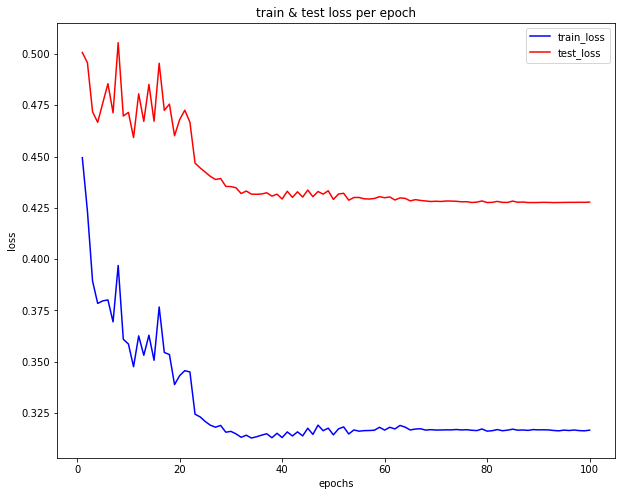

In [14]:
plt.figure(figsize=(10,8))

plt.plot(range(1, 101), train_loss, 'b-', label='train_loss')
plt.plot(range(1, 101), test_loss, 'r-', label='test_loss')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('train & test loss per epoch')
plt.legend()

plt.show()

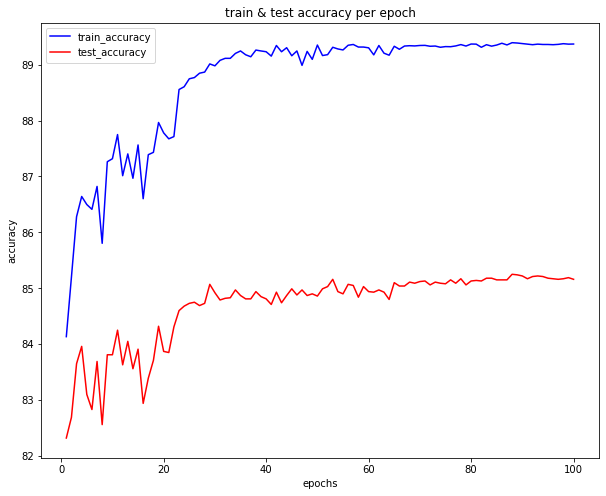

In [15]:
plt.figure(figsize=(10,8))

plt.plot(range(1, 101), train_accuracy, 'b-', label='train_accuracy')
plt.plot(range(1, 101), test_accuracy, 'r-', label='test_accuracy')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('train & test accuracy per epoch')
plt.legend()

plt.show()

In [16]:
print(f'Best epoch: {best_epoch}')
print(f'Train: accuracy: {best_train_accuracy:>0.1f}%, avg loss: {best_train_loss:>8f}')
print(f'Test: accuracy: {best_test_accuracy:>0.1f}%, avg loss: {best_test_loss:>8f}')

Best epoch: 88
Train: accuracy: 89.4%, avg loss: 0.316517
Test: accuracy: 85.2%, avg loss: 0.427559


## 5.4 Model metrics

In [17]:
print(f'Train:\n{classification_report(best_train_y, best_train_pred, target_names=target_names)}')
print(f'Test:\n{classification_report(best_test_y, best_test_pred, target_names=target_names)}')

Train:
              precision    recall  f1-score   support

    airplane       0.91      0.93      0.92      5000
  automobile       0.95      0.95      0.95      5000
        bird       0.90      0.82      0.86      5000
         cat       0.81      0.80      0.80      5000
        deer       0.83      0.87      0.85      5000
         dog       0.87      0.84      0.85      5000
        frog       0.88      0.93      0.90      5000
       horse       0.91      0.91      0.91      5000
        ship       0.94      0.95      0.94      5000
       truck       0.93      0.95      0.94      5000

    accuracy                           0.89     50000
   macro avg       0.89      0.89      0.89     50000
weighted avg       0.89      0.89      0.89     50000

Test:
              precision    recall  f1-score   support

    airplane       0.88      0.88      0.88      1000
  automobile       0.91      0.91      0.91      1000
        bird       0.86      0.78      0.82      1000
         ca

<AxesSubplot:>

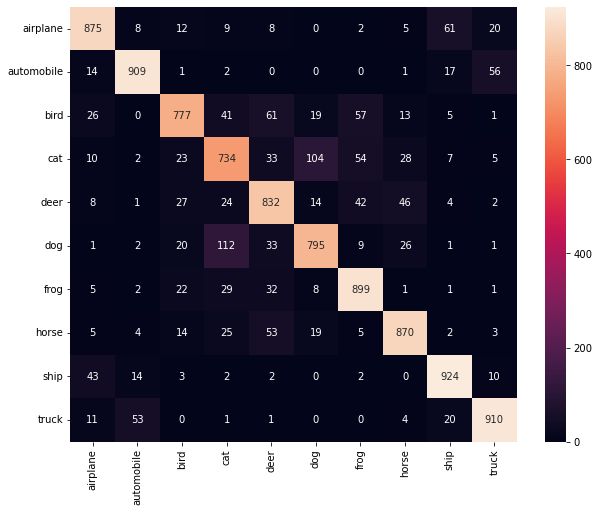

In [18]:
cm = confusion_matrix(best_test_y, best_test_pred)
sns.heatmap(cm, annot=True, fmt='', xticklabels=target_names, yticklabels=target_names, ax=plt.subplots(figsize=(10,8))[1])

## 5.5 Save model

In [19]:
torch.save(best_model_state_dict, '../saved-model/vgg16-weights.pth')